<a href="https://colab.research.google.com/github/hyun1994/AVLTREE.py/blob/main/stock_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from datetime import datetime

In [3]:
stock_df = pd.read_csv('/content/MyDrive/MyDrive/Colab Notebooks/stock.adj_close.csv')

In [8]:
stock_df # 주가를 통해서 다음날 주가 예측

,Symbol,2018-06-01,2018-06-04,2018-06-05,2018-06-07,2018-06-08,2018-06-11,2018-06-12,2018-06-14,2018-06-15,2018-06-18,2018-06-19,2018-06-20,2018-06-21,2018-06-22,2018-06-25,2018-06-26,2018-06-27,2018-06-28,2018-06-29,2018-07-02,2018-07-03,2018-07-04,2018-07-05,2018-07-06,2018-07-09,2018-07-10,2018-07-11,2018-07-12,2018-07-13,2018-07-16,2018-07-17,2018-07-18,2018-07-19,2018-07-20,2018-07-23,2018-07-24,2018-07-25,2018-07-26,2018-07-27,...,2020-07-24,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-31,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18
0,A000020,11550.0,11750.0,11700.0,11650.0,11500.0,11500.0,11650.0,12000.0,11800.0,11450.0,10850.0,11200.0,11000.0,11150.0,10900.0,11000.0,10750.0,10300.0,10200.0,9940.0,10000.0,10450.0,10400.0,10450.0,10450.0,10500.0,10500.0,10800.0,10950.0,10800.0,11050.0,10950.0,10600.0,10500.0,10350.0,10700.0,10200.0,10500.0,10650.0,...,23050.0,23000.0,23450.0,24050.0,23300.0,24400.0,24050.0,26000.0,28100.0,28350.0,29350.0,30300.0,24400.0,24950.0,22550.0,21200.0,22000.0,22900.0,22850.0,21650.0,23100.0,23250.0,23750.0,23750.0,23050.0,23450.0,23650.0,24950.0,25350.0,25200.0,25550.0,23650.0,24550.0,25950.0,26750.0,26300.0,25400.0,25050.0,25300.0,25050.0
1,A000030,15500.0,15950.0,16050.0,16500.0,16600.0,16650.0,16850.0,16500.0,16100.0,16350.0,16350.0,16350.0,16350.0,16350.0,16350.0,16500.0,16100.0,15850.0,16300.0,16350.0,16450.0,16400.0,16250.0,16750.0,17000.0,16600.0,16700.0,16500.0,16950.0,16650.0,16500.0,16400.0,16400.0,16500.0,16600.0,16500.0,16750.0,16700.0,16850.0,...,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0,14800.0
2,A000040,2992.0,3021.0,3025.0,3069.0,3045.0,2984.0,2976.0,3033.0,3033.0,3017.0,3017.0,2992.0,2907.0,2834.0,2724.0,2607.0,2550.0,2448.0,2448.0,2339.0,2347.0,2298.0,2310.0,2318.0,2586.0,2590.0,2578.0,2570.0,2558.0,2566.0,2558.0,2513.0,2473.0,2436.0,2420.0,2399.0,2379.0,2391.0,2395.0,...,731.0,738.0,724.0,724.0,716.0,712.0,686.0,702.0,729.0,760.0,744.0,718.0,702.0,719.0,707.0,706.0,688.0,690.0,671.0,671.0,679.0,705.0,703.0,673.0,686.0,705.0,735.0,923.0,894.0,950.0,980.0,932.0,741.0,875.0,840.0,860.0,833.0,817.0,812.0,796.0
3,A000050,13200.0,13550.0,13600.0,13800.0,13800.0,13800.0,13650.0,13850.0,14500.0,14550.0,14250.0,14200.0,14100.0,13550.0,13800.0,13900.0,14250.0,14200.0,13850.0,13800.0,13550.0,13800.0,13800.0,13800.0,13850.0,13700.0,14350.0,13950.0,13850.0,13700.0,13750.0,13750.0,13400.0,13250.0,13200.0,13050.0,12650.0,12650.0,12900.0,...,11450.0,12000.0,11700.0,11750.0,11500.0,11400.0,11300.0,11200.0,11400.0,11450.0,11700.0,11700.0,11750.0,11900.0,11950.0,11850.0,10900.0,10800.0,11250.0,10850.0,10800.0,10900.0,10950.0,10500.0,10500.0,10550.0,10300.0,10550.0,10850.0,10900.0,11100.0,11350.0,11550.0,11500.0,11550.0,11300.0,11300.0,11050.0,10900.0,10750.0
4,A000060,20050.0,20050.0,20150.0,20050.0,20400.0,20150.0,20700.0,20950.0,20150.0,20900.0,21100.0,20700.0,19700.0,20000.0,19550.0,19400.0,19200.0,19300.0,19200.0,19150.0,19300.0,19450.0,19250.0,19550.0,19500.0,19350.0,19150.0,19200.0,18950.0,18700.0,18600.0,18650.0,18700.0,18250.0,18350.0,18550.0,18700.0,18300.0,18650.0,...,12800.0,12700.0,12650.0,12700.0,12600.0,12400.0,12150.0,12550.0,12550.0,12600.0,12400.0,12550.0,12950.0,13450.0,13550.0,13400.0,12850.0,12850.0,12350.0,12700.0,12550.0,12900.0,12700.0,12650.0,12800.0,12750.0,12650.0,12650.0,12750.0,12600.0,12700.0,12700.0,12650.0,12700.0,12800.0,13000.0,13200.0,13150.0,13150.0,13200.0
...,...,.

In [5]:
def print_grapah(index): # 그래프 생성하기 위해 str / int 분리하고 각 종목의 인덱스 input하면 그래프 생성함수
    stock_df.loc[index][1:].plot()
    plt.show()

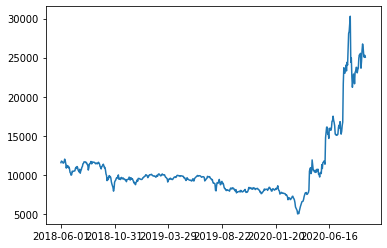

In [6]:
print_grapah(0)

In [21]:
dataset = stock_df.dropna() # NaN 값 제거

In [55]:
high_value = dataset.max(axis=1) # 종목의 고점
low_value = dataset.min(axis=1) # 종목의 저점
middle_value = dataset.mean(axis=1)# 종목의 중간점
print(middle_value)

0       10772.385563
1       15166.373239
2        1710.778169
3       10980.035211
4       18234.559859
            ...     
2266    10246.021127
2267     5054.436620
2268     5039.014085
2269    20707.077465
2270     7361.021127
Length: 1996, dtype: float64


In [27]:
seq_len = 50 # 50일 데이터를 활용
sequence_len = seq_len + 1 # 50일 데이터를 활용해서 그 다음날 예측

result = []
for index in range(len(middle_value) - sequence_len):
  result.append(middle_value[index:index + sequence_len])

In [28]:
print(result)

[0      17642.5
1      15850.0
2       1755.0
3      10700.0
4      17390.0
5      78750.0
6      30900.0
7      49944.0
8     154500.0
9      15355.0
10     69348.0
11      2115.0
12     85250.0
13     14035.0
14     10242.5
15     13220.0
16     41075.0
17     35000.0
18       897.5
19     10565.0
20      4127.5
21      6375.0
22      2020.0
23      3897.5
24      9675.0
25     89050.0
26      6077.5
27     19225.0
28     24550.0
29      3930.0
30     61425.0
31     91850.0
32     66725.0
33     81350.0
34    627500.0
35      2420.0
36      6525.0
37     45800.0
38     18425.0
39    217500.0
40     41425.0
41     21325.0
42     24350.0
43      1430.0
44      5860.0
45     20750.0
46     10300.0
47     24525.0
48      2279.5
49      2455.5
50     99394.0
dtype: float64, 1      15850.0
2       1755.0
3      10700.0
4      17390.0
5      78750.0
6      30900.0
7      49944.0
8     154500.0
9      15355.0
10     69348.0
11      2115.0
12     85250.0
13     14035.0
14     10242.5
15     1

In [29]:
normalized_data = [] # 윈도우를 조금 더 정교하게 하기 위해서
window_mean = []
window_std = []
for window in result:
  normalized_window = [((p - np.mean(window)) / np.std(window))for p in window]
  normalized_data.append(normalized_window)
  window_mean.append(np.mean(window))
  window_std.append(np.std(window))

result = np.array(normalized_data)

In [30]:
row = int(round(result.shape[0]*0.9)) # 9:1 트레인셋과 테스트셋 분리
train = result[:row,:]

np.random.shuffle(train)

x_train = train[:,:-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1750, 50, 1), (195, 50, 1))

In [32]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 21,057
Trainable params: 21,057
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size = 10,
          epochs= 10)

Epoch 1/10
175/175 [==============================] - 26s 34ms/step - loss: 0.9099 - val_loss: 0.6827
Epoch 2/10
175/175 [==============================] - 5s 28ms/step - loss: 0.4921 - val_loss: 0.6024
Epoch 3/10
175/175 [==============================] - 5s 28ms/step - loss: 0.2576 - val_loss: 0.1611
Epoch 4/10
175/175 [==============================] - 5s 28ms/step - loss: 0.2251 - val_loss: 0.3230
Epoch 5/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0936 - val_loss: 0.7749
Epoch 6/10
175/175 [==============================] - 5s 28ms/step - loss: 0.1699 - val_loss: 0.0926
Epoch 7/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0868 - val_loss: 0.0895
Epoch 8/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0930 - val_loss: 0.1509
Epoch 9/10
175/175 [==============================] - 5s 28ms/step - loss: 0.1003 - val_loss: 0.0540
Epoch 10/10
175/175 [==============================] - 5s 28ms/step - loss: 0.0549 - val_l

In [34]:
pred = model.predict(x_test)

In [35]:
pred_result = []
pred_y = []

for i in range(len(pred)):
  n1 = (pred[i] * window_std[i]) + window_mean[i]
  n2 = (y_test[i] * window_std[i]) + window_mean[i]
  pred_result.append(n1)
  pred_y.append(n2)

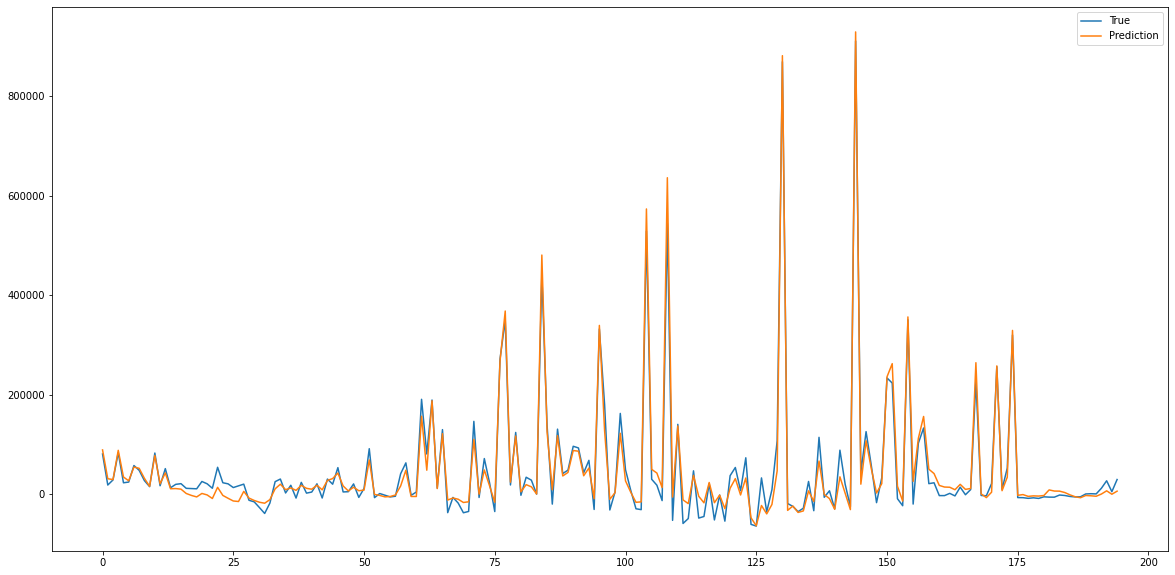

In [39]:
fig = plt.figure(facecolor='white', figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(pred_y, label = 'True')
ax.plot(pred_result, label='Prediction')
ax.legend()
plt.show()